<a href="https://colab.research.google.com/github/44REAM/CEB-image_processing/blob/main/Diffusion_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diffusion tensor imaging (DTI)
---


# Resources

- MRI image acquisition: https://www.youtube.com/playlist?list=PLIfBbrWfKu6-XPvqWM6aZhlKKOuRLIJWG
- MRI question: https://mriquestions.com/index.html
- DWI: http://xrayphysics.com/dwi.html
- Tensor: https://www.youtube.com/watch?v=f5liqUk0ZTw&t=126s
- Tensor image: https://www.youtube.com/watch?v=YxXyN2ifK8A
- Review practical use of DWI in brain image: https://www.mdpi.com/2072-6694/15/3/618

In [41]:
!git clone https://github.com/44REAM/CEB-image_processing.git
%cd /content/CEB-image_processing
!pip install dipy

fatal: destination path 'CEB-image_processing' already exists and is not an empty directory.
/content/CEB-image_processing
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# DTI reconstruction

In [42]:
import numpy as np

from dipy.data import get_fnames
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table

import dipy.reconst.dti as dti
import matplotlib.pyplot as plt

## Data

- DWI image: 4D image (x, y, z, sequence). (You can see the 4D image as sequences of 3D image)
- b value: factor that reflects the strength and timing of the gradients used to generate diffusion-weighted images.
- b vector: Direction of the gradient


In [43]:

# get name of the data
hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')

data, affine = load_nifti(hardi_fname) 

bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)

print('data.shape (%d, %d, %d, %d)' % data.shape)

data.shape (81, 106, 76, 160)


In [44]:
print(data.shape)
print(bvals.shape)
print(bvecs.shape)

(81, 106, 76, 160)
(160,)
(160, 3)


In [74]:
maskdata2, mask2 = median_otsu(data, vol_idx=range(0, 9),
                             numpass=1, dilate=5)

In [76]:
print('maskdata2.shape (%d, %d, %d, %d)' % maskdata2.shape)

maskdata2.shape (81, 106, 76, 160)


In [72]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)

print('data.shape (%d, %d, %d, %d)' % data.shape)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

data.shape (81, 106, 76, 160)
maskdata.shape (71, 88, 62, 160)


## Apparent Diffusion Coefficient

The simplest assumption on the diffusion is the water molecule can diffuse equally in all direction (***Isotropic diffusion***). We can write the image intensity after apply the diffusion gradient as below.

$$I = I_0 * e^{-b * D_{ADC}}$$

where $I_0$ is intensity of the image without magnetic gradient. $b$ is bvalue and $D_{ADC}$ is the diffusion coeffient. By fitting the equation we can get image of $D_{ADC}$ called, apparent diffusion coefficient (ADC) map.

The ADC map is a pure display of consolidated ADC values. Tissues with restrict diffusion (low ADC values) (stroke, abscesses, etc.) appear dark, while materials like CSF (no restriction) with high ADC values appear bright.

## Diffusion Tensor image

Actually the water not diffuse equally in all direction, for example, diffuse along in direction of axon (this is because myelin sheaths encircle the neurons and prevent water diffusion across the sheath). Diffusion that is directionally dependent is referred to as ***anisotropic diffusion***.

$$I = I_0 * e^{-b * g^TD_{DTI}  g }$$

Where $b$ is the b value, $g$ is b vector and $D_{DTI} $ is diffusion tensor.

In [46]:
gtab = gradient_table(bvals, bvecs)
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata)

### What is diffusion tensor?

https://www.youtube.com/watch?v=f5liqUk0ZTw&t=126s

In this case you can view diffusion tensor as a model parameter that described transformation of the image in each voxel (How the water in each voxel move).

$$
D_{DTI} = 
\begin{bmatrix} 
D_{xx} & D_{xy} & D_{xz} \\ 
D_{yx} & D_{yy} & D_{yz} \\ 
D_{zx} & D_{zy} & D_{zz}
\end{bmatrix}
$$

#### Diffusion Tensor are symmetric

Diffusion Tensor are symmetric since x→y ($D_{xy}$) and y→x ($D_{yx}$) diffusivities should be the same. 

In [47]:
# diffusion tensor per voxel
print(f"shape of output {tenfit.quadratic_form.shape} \n")

# diffusion tensor at voxel (0,0,0)
x = 0; y=0; z=0
print(f"diffusion tensor at voxel ({x},{y},{z})")
print(tenfit.quadratic_form[x,y,z,:,:])

shape of output (71, 88, 62, 3, 3) 

diffusion tensor at voxel (0,0,0)
[[ 5.00006825e-10  1.16322274e-25  0.00000000e+00]
 [ 9.04728795e-26  5.00006825e-10 -3.87740912e-26]
 [ 0.00000000e+00 -3.87740912e-26  5.00006825e-10]]


For each diffusion tensor (view as transformation matrix per voxel), we can calculate the property of transformation such as eigenvalue and eigenvector. The eigenvector here describe the direction of diffusion and eigenvalue that corresponse to eigenvector describe strength of diffusion. Common image that extracted from DTI are fractional anisotropy (FA) and Mean diffusivity (MD) (or ADC).





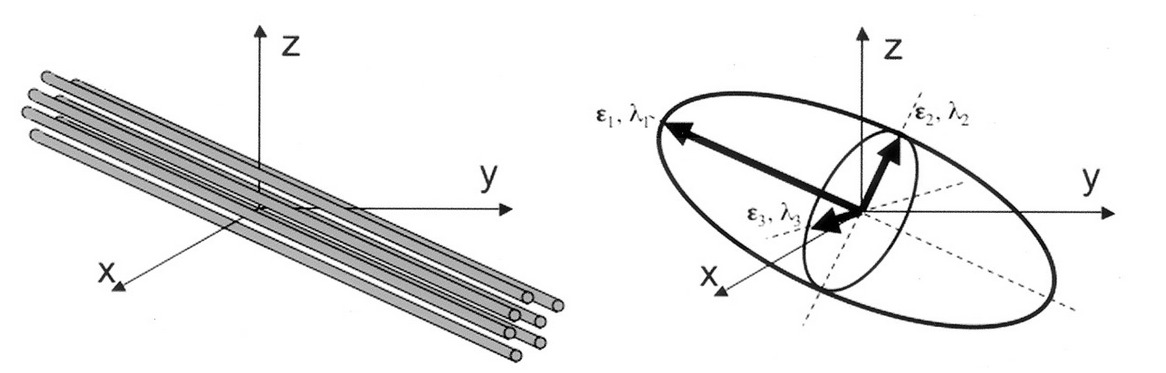

The $D_{ADC}$ can be calculate by using average of the diffusion in three direction $x, y, z$ $(D_{xx}, D_{yy}, D_{zz})$

$$D_{ADC}= MD = \frac{D_{xx}+ D_{yy}+ D_{zz}}{3} = \frac{λ_1+λ_2+λ_3}{3}$$

In otherword, $D_{ADC}$ is the average of an eigenvalue.

$$FA = \sqrt{\frac{3}{2}} \frac
{\sqrt{(λ_1-\hat{\lambda})^2 + (λ_2-\hat{\lambda})^2 + (λ_3-\hat{\lambda})^2}}
{\sqrt{(λ_1^2+λ_2^2+λ_3^2)}}$$

Where $\hat{\lambda} = MD$

In [63]:
# eigenvectors
print(tenfit.evecs.shape)

# eigenvalues
print(tenfit.evals.shape)

(71, 88, 62, 3, 3)
(71, 88, 62, 3)


In [48]:
# MD = dti.mean_diffusivity(tenfit.evals)
MD = tenfit.md

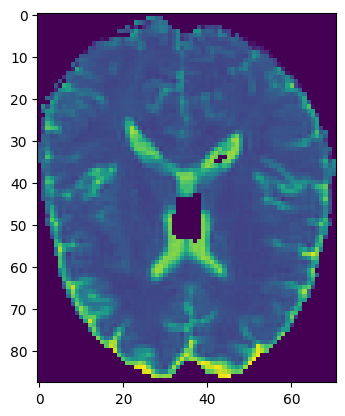

In [49]:
plt.imshow(MD[:,:,30].T)

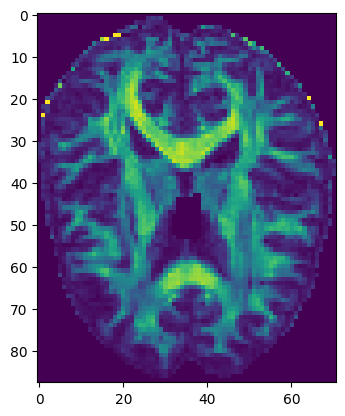

In [61]:
from dipy.reconst.dti import fractional_anisotropy
FA = tenfit.fa
FA = np.clip(FA, 0, 1)
plt.imshow(FA[:,:,30].T)

In [57]:
tenfit.evals.shape

(71, 88, 62, 3)

In [60]:
tenfit.evecs[0,0,0]

array([[-0.39210914,  0.87851087, -0.27289021],
       [-0.8686677 , -0.45122993, -0.20446997],
       [-0.30276532,  0.15687637,  0.9400654 ]])

#### FA with color

- red indicates that diffusion is higher on right-left directions
- green indicates that diffusion is higher on anterior-posterior directions
- blue indicates that diffusion is higher on inferior-superior directions


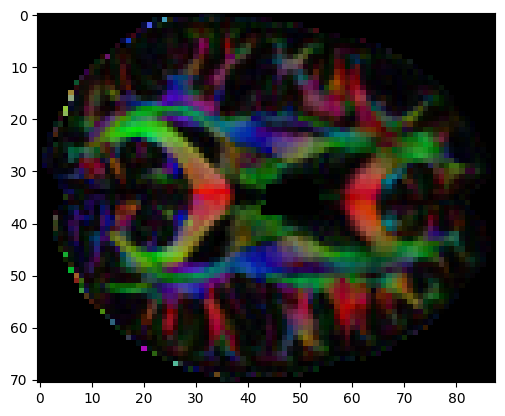

In [54]:
from dipy.reconst.dti import color_fa
colored_FA = color_fa(FA, tenfit.evecs)
plt.imshow(colored_FA[:,:,30])